# **How often are appointments missed in the SNEE footprint?**

- This is required so that we can model the number of appointments missed, as this will require the patient to re-attend in the model at a later date.

- Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

- [using multiple years] Are the missed appointment %ages consistent over time (compare years, statistical tests)?

- Across staff groups & Sub-ICB, are some appointments more likely to be missed?

- Using the analysis from the above, what is the mean likelihood that someone (from a combination of)
    - Sub-ICB
    - Staff type
    - Appointment type
    - Will not attend?

- Suggest an appropriate distribution to sample from, to determine if a patient with the above appointment will attend.
Persist the distribution information from 5. to a yaml file.

### **Importing libraries**

In [1]:
# this is a bit of a hack to get relative imports 
# to work as if these notebooks were in a package

from os import chdir
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    chdir('..')

# Library imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import category_encoders

# project imports from src
from src.schemas import DataCatalog
from src.various_methods import *

### **Loading the catalog**

In [2]:
# Loading the Data Catalog
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

# Initializing the plotCounter object
plot_counter = PlotCounter(name='appointment_attendance')

### **Loading the dataset 'NHS GP Appointments by Region' for appointments data**

In [4]:
gp_appts_catalog_entry = catalog.single_data_sources[0]
gp_appts_df = gp_appts_catalog_entry.load()
print(gp_appts_catalog_entry.zip_file.namelist())

# Combining data for all the ICB's
dfs = []
for ccg_name in gp_appts_catalog_entry.zip_file.namelist():
    gp_appts_catalog_entry.csv_file = ccg_name
    dfs.append(gp_appts_catalog_entry.load())

combined_df = pd.concat(dfs, axis=0)
combined_df.head()

['Regional_CSV_WYorks.csv', 'Regional_CSV_Sussex.csv', 'Regional_CSV_SurreyHearts.csv', 'Regional_CSV_SuffolkNEEssex.csv', 'Regional_CSV_StaffsStoke.csv', 'Regional_CSV_Somerset.csv', 'Regional_CSV_ShropsTelfordWrekin.csv', 'Regional_CSV_SYorks.csv', 'Regional_CSV_SWLondon.csv', 'Regional_CSV_SELondon.csv', 'Regional_CSV_NottinghamNotts.csv', 'Regional_CSV_Northamptonshire.csv', 'Regional_CSV_NorfolkWaveney.csv', 'Regional_CSV_NWLondon.csv', 'Regional_CSV_NENCumbria.csv', 'Regional_CSV_NELondon.csv', 'Regional_CSV_NCLondon.csv', 'Regional_CSV_MidSEssex.csv', 'Regional_CSV_Lincolnshire.csv', 'Regional_CSV_LeicesterLshire.csv', 'Regional_CSV_LancsSCumbria.csv', 'Regional_CSV_KentMedway.csv', 'Regional_CSV_HumberNYorks.csv', 'Regional_CSV_HertfordshireWEssex.csv', 'Regional_CSV_HereWorcs.csv', 'Regional_CSV_HampshireIoW.csv', 'Regional_CSV_Gloucestershire.csv', 'Regional_CSV_GManchesterHSCP.csv', 'Regional_CSV_FrimleyHealth.csv', 'Regional_CSV_Dorset.csv', 'Regional_CSV_Devon.csv', 'Regio

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS
0,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,1 Day,1999
1,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,15 to 21 Days,329
2,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,2 to 7 Days,4194
3,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,22 to 28 Days,212
4,02T,E38000025,NHS West Yorkshire ICB - 02T,E54000054,NHS West Yorkshire Integrated Care Board,E40000012,North East and Yorkshire,MAR2021,Attended,GP,Face-to-Face,8 to 14 Days,1101


In [5]:
combined_df['APPT_MODE'].unique()

array(['Face-to-Face', 'Home Visit', 'Telephone', 'Video/Online',
       'Unknown'], dtype=object)

#### **Data pre-processing**
1. Removing un-necessary columns and making a copy  
   
2. Changing APPOINTMENT_MONTH to FY_YEAR  
  
**Note: (FY2023 only from april to august)**

In [6]:
combined_df['APPOINTMENT_MONTH'].unique()

array(['MAR2021', 'APR2021', 'MAY2021', 'JUN2021', 'JUL2021', 'AUG2021',
       'SEP2021', 'OCT2021', 'NOV2021', 'DEC2021', 'JAN2022', 'FEB2022',
       'MAR2022', 'APR2022', 'MAY2022', 'JUN2022', 'JUL2022', 'AUG2022',
       'SEP2022', 'OCT2022', 'NOV2022', 'DEC2022', 'JAN2023', 'FEB2023',
       'MAR2023', 'APR2023', 'MAY2023', 'JUN2023', 'JUL2023', 'AUG2023'],
      dtype=object)

In [7]:
needed_cols = ['ICB_NAME','SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPOINTMENT_MONTH','APPT_STATUS','HCP_TYPE','APPT_MODE','COUNT_OF_APPOINTMENTS']

combined_df_copy = combined_df[needed_cols].copy()

# Replacing months values to FY- years
combined_df_copy['APPOINTMENT_MONTH'] = combined_df_copy['APPOINTMENT_MONTH'].replace({'APR2021':'FY2021', 'MAY2021':'FY2021', 'JUN2021':'FY2021', 'JUL2021':'FY2021', 'AUG2021':'FY2021', 'SEP2021':'FY2021',
                                                                                       'OCT2021':'FY2021', 'NOV2021':'FY2021', 'DEC2021':'FY2021', 'JAN2022':'FY2021', 'FEB2022':'FY2021', 'MAR2022':'FY2021',
                                                                                       'APR2022':'FY2022', 'MAY2022':'FY2022', 'JUN2022':'FY2022', 'JUL2022':'FY2022', 'AUG2022':'FY2022', 'SEP2022':'FY2022',
                                                                                       'OCT2022':'FY2022', 'NOV2022':'FY2022', 'DEC2022':'FY2022', 'JAN2023':'FY2022', 'FEB2023':'FY2022', 'MAR2023':'FY2022',
                                                                                       'APR2023':'FY2023', 'MAY2023':'FY2023', 'JUN2023':'FY2023', 'JUL2023':'FY2023', 'AUG2023':'FY2023'})

combined_df_copy = combined_df_copy.loc[combined_df_copy['APPOINTMENT_MONTH']!='MAR2021'].rename(columns={'APPOINTMENT_MONTH':'FY_YEAR'})
combined_df_copy['FY_YEAR'].unique()

array(['FY2021', 'FY2022', 'FY2023'], dtype=object)

## **Analysis using mean of appointments**

### **Creating separate DF's for Attend and DNA appointments based on FY-YEARS**

In [8]:
# Dataframe for appointments attended
attended_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','FY_YEAR']).mean().round(4)
attended_df.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                       
NHS Bath and North East Somerset, Swindon and W... FY2021               6441.2406
                                                   FY2022               6409.7105
                                                   FY2023               5193.6111
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021               6031.7656
                                                   FY2022               6074.6977

In [9]:
# Dataframe for appointments DNA
do_not_attend_df = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','HCP_TYPE','APPT_MODE']).groupby(['ICB_NAME','FY_YEAR']).mean().round(4)
do_not_attend_df.head()

COUNT_OF_APPOINTMENTS
ICB_NAME                                           FY_YEAR                       
NHS Bath and North East Somerset, Swindon and W... FY2021                296.6420
                                                   FY2022                297.7442
                                                   FY2023                216.5930
NHS Bedfordshire, Luton and Milton Keynes Integ... FY2021                303.7700
                                                   FY2022                349.3905

### **Comparing the National average with SNEE**

#### **1. Attended appointments**

In [10]:
National_average_attended = attended_df['COUNT_OF_APPOINTMENTS'].mean().round(4)
National_average_attended_2022 = attended_df.loc[slice(None),'FY2022',:].mean().round(4)
SNEE_average_attended = attended_df.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_attended.item()} is the National average for attended appointments(FY-2021-22-23)')
print(f'{SNEE_average_attended.mean().item()} is the SNEE average for attended appointments(FY-2021-22-23)')
print(f'{National_average_attended_2022.item()} is the national average for attended appointments(FY-2022)')

SNEE_average_attended

4414.3347 is the National average for attended appointments(FY-2021-22-23)
2067.6403 is the SNEE average for attended appointments(FY-2021-22-23)
4763.7655 is the national average for attended appointments(FY-2022)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,2187.6634
FY2022,2178.0886
FY2023,1837.1689


#### **2. Not attended (DNA) Appointments**

In [11]:
National_average_DNA = do_not_attend_df['COUNT_OF_APPOINTMENTS'].mean().round(4)
National_average_DNA_2022 = do_not_attend_df.loc[slice(None),'FY2022',:].mean().round(4)
SNEE_average_DNA = do_not_attend_df.loc['NHS Suffolk and North East Essex Integrated Care Board',:]

print(f'{National_average_DNA.item()} is the National average for DNA appointments (FY-2021-22-23)')
print(f'{SNEE_average_DNA.mean().item()} is the SNEE average for DNA appointments(FY-2021-22-23)')
print(f'{National_average_DNA_2022.item()} is the National average DNA attend appointments(FY-2022)')

SNEE_average_DNA

304.1467 is the National average for DNA appointments (FY-2021-22-23)
101.2273 is the SNEE average for DNA appointments(FY-2021-22-23)
334.4385 is the National average DNA attend appointments(FY-2022)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,106.1100
FY2022,106.1922
FY2023,91.3797


### **Plotting the mean appointments for attended and non-attended based on FY-Years**

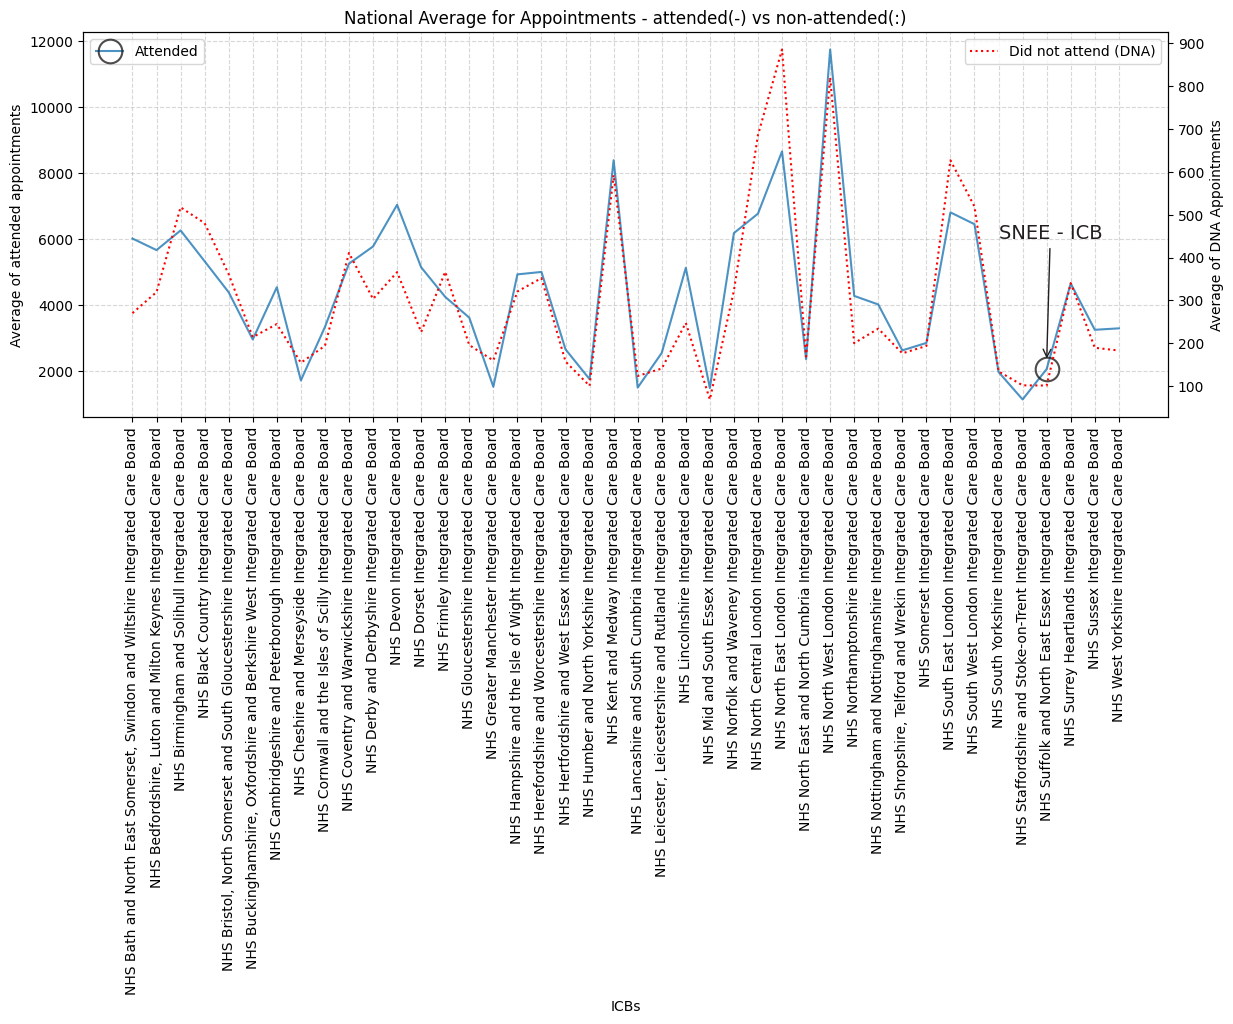

In [12]:
attended_df2 = attended_df.groupby('ICB_NAME').mean().reset_index()
do_not_attend_df2 = do_not_attend_df.groupby('ICB_NAME').mean().reset_index()
snee = 'NHS Suffolk and North East Essex Integrated Care Board'

# Plotting attended vs dna for FY-2021-22-23
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
plt.xlabel('ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylabel('Average of attended appointments')
plt.title('National Average for Appointments - attended(-) vs non-attended(:)')
ax = sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=attended_df2, label = 'Attended', alpha=0.8, marker = 'o', markersize=17, fillstyle='none', markeredgewidth=1.5, markeredgecolor='#231f20', markevery=[38])
ax.annotate('SNEE - ICB',xy=(38,2300), xytext=(36,6000), arrowprops =dict(arrowstyle='->',color='#231f20'),color='#231f20', fontsize=14)
ax.legend(loc = 'upper left')

# Creating secondary y-axis
ax2 = ax.twinx()
ax2.set_ylabel('Average of DNA Appointments')
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=do_not_attend_df2, color ='red', linestyle=':', ax=ax2, label ='Did not attend (DNA)')

plt.savefig(f'outputs/plots/{plot_counter.plot_name}.png', dpi=300, bbox_inches='tight')

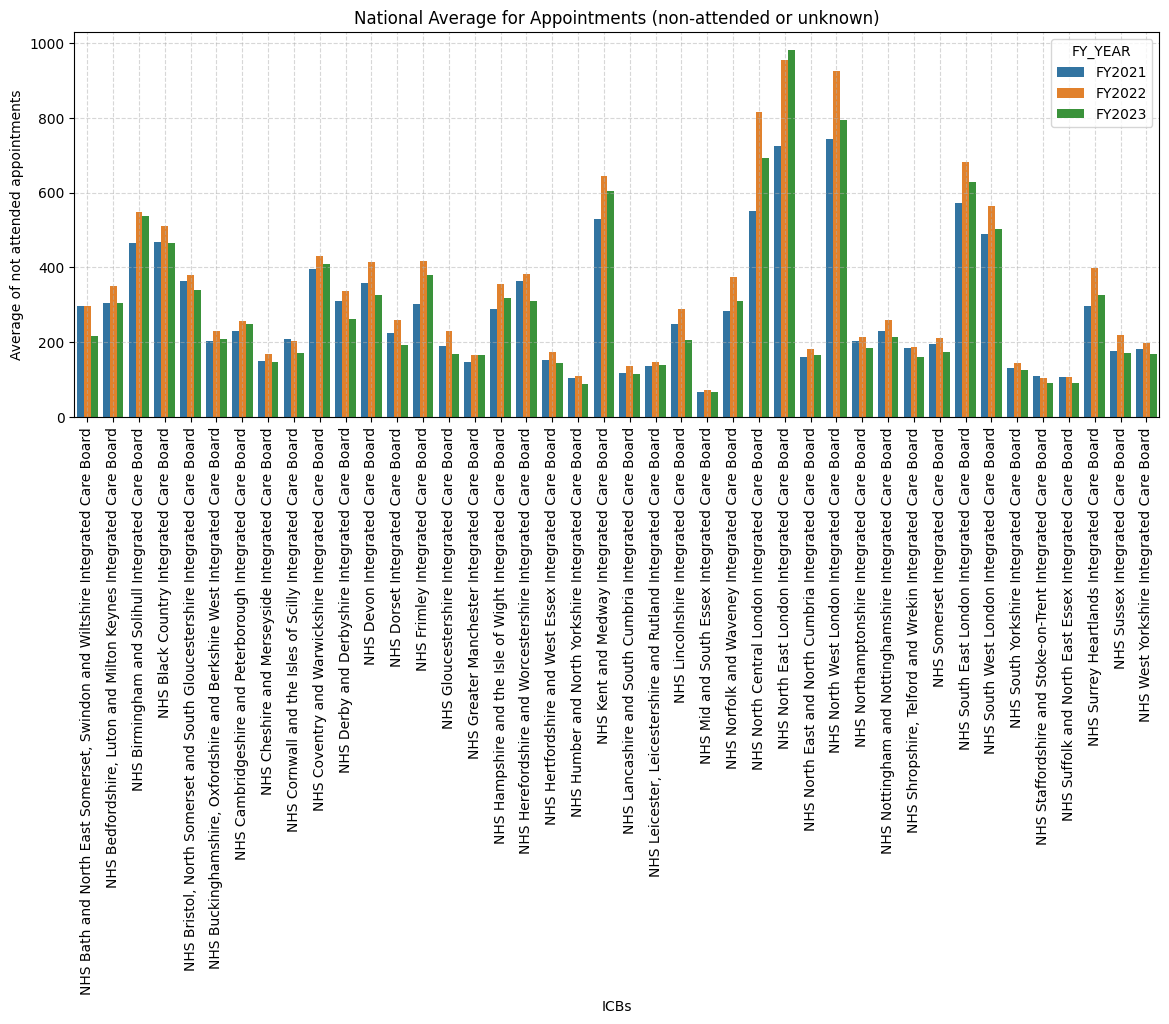

In [13]:
# Plotting the did not attended 
plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
sns.barplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS', data=do_not_attend_df, hue='FY_YEAR')
plt.xlabel('ICBs')
plt.ylabel('Average of not attended appointments')
plt.title('National Average for Appointments (non-attended or unknown)')
plt.grid(True, linestyle='--', alpha=0.5)

### **Creating separate DF's for Attend and DNA appointments based on HCP-type and Appointment-mode**

In [14]:
# Dataframe for appointments attended
attended_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'Attended'].drop(columns=['SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','FY_YEAR']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).mean().round(4)
attended_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP       Face-to-Face             14436.9871
                                                            Home Visit                 142.7819
                                                            Telephone                11148.2478
                                                            Unknown                     23.3611
                                                            Video/Online               102.5330
...                                                                                         ...
NHS West Yorkshire Integrated Care Board           Unknown  Face-to-Face                66.9141
                                                            Home Visit                  19.0409
                                                            Telephone                  342.0952
                                                            Unknown                    915.0151
                                                            Video/Online                28.3333

[600 rows x 1 columns]

In [15]:
# Dataframe for appointments DNA
dna_hcptype_apptmode = combined_df_copy.loc[combined_df_copy['APPT_STATUS'] == 'DNA'].drop(columns=['SUB_ICB_LOCATION_NAME','SUB_ICB_LOCATION_ONS_CODE','APPT_STATUS','FY_YEAR']).groupby(['ICB_NAME','HCP_TYPE','APPT_MODE']).mean().round(4)
dna_hcptype_apptmode

COUNT_OF_APPOINTMENTS
ICB_NAME                                           HCP_TYPE             APPT_MODE                          
NHS Bath and North East Somerset, Swindon and W... GP                   Face-to-Face               393.8976
                                                                        Home Visit                   4.1333
                                                                        Telephone                   47.4483
                                                                        Unknown                      2.0000
                                                                        Video/Online                 3.2604
...                                                                                                     ...
NHS West Yorkshire Integrated Care Board           Other Practice staff Video/Online                 9.1938
                                                   Unknown              Face-to-Face                 1.3333
                                                                        Home Visit                   1.6000
                                                                        Telephone                    7.4348
                                                                        Unknown                     30.2217

[564 rows x 1 columns]

### **Plotting the mean DNA apointments based on HCP-TYPE and APPOINTMENT MODE**

In [16]:
# Calculating National average for GP's for DNA Appointments
DNA_GP_f2f = dna_hcptype_apptmode.loc[(slice(None),'GP','Face-to-Face'),:].mean().round(4).item()
DNA_GP_homevisit = dna_hcptype_apptmode.loc[(slice(None),'GP','Home Visit'),:].mean().round(4).item()
DNA_GP_tel = dna_hcptype_apptmode.loc[:,'GP','Telephone'].mean().round(4).item()
DNA_GP_unknown = dna_hcptype_apptmode.loc[:,'GP','Unknown'].mean().round(4).item()
DNA_GP_video_online = dna_hcptype_apptmode.loc[:,'GP','Video/Online'].mean().round(4).item()

# Calculating National average for Other Practice staff for DNA Appointments
DNA_p_staff_f2f = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Face-to-Face'),:].mean().round(4).item()
DNA_p_staff_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Other Practice staff','Home Visit'),:].mean().round(4).item()
DNA_p_staff_tel = dna_hcptype_apptmode.loc[:,'Other Practice staff','Telephone'].mean().round(4).item()
DNA_p_staff_unknown = dna_hcptype_apptmode.loc[:,'Other Practice staff','Unknown'].mean().round(4).item()
DNA_p_staff_video_online = dna_hcptype_apptmode.loc[:,'Other Practice staff','Video/Online'].mean().round(4).item()

# Calculating National average for Unknown for DNA Appointments
DNA_unknown_f2f = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Face-to-Face'),:].mean().round(4).item()
DNA_unknown_homevisit = dna_hcptype_apptmode.loc[(slice(None),'Unknown','Home Visit'),:].mean().round(4).item()
DNA_unknown_tel = dna_hcptype_apptmode.loc[:,'Unknown','Telephone'].mean().round(4).item()
DNA_unknown_unknown = dna_hcptype_apptmode.loc[:,'Unknown','Unknown'].mean().round(4).item()
DNA_unknown_video_online = dna_hcptype_apptmode.loc[:,'Unknown','Video/Online'].mean().round(4).item()


data = {
    'GP' : [DNA_GP_f2f, DNA_GP_homevisit, DNA_GP_tel, DNA_GP_unknown, DNA_GP_video_online],
    'Practice staff' : [DNA_p_staff_f2f, DNA_p_staff_homevisit, DNA_p_staff_tel, DNA_p_staff_unknown, DNA_p_staff_video_online],
    'Unknown' : [DNA_unknown_f2f, DNA_unknown_homevisit, DNA_unknown_tel, DNA_unknown_unknown, DNA_unknown_video_online]
}

index_values = ['Face to face', 'Home visit', 'Telephone', 'Unknown', 'Video/Online']

national_average_dna_hcp_appt_type = pd.DataFrame(data, index=index_values)
national_average_dna_hcp_appt_type

,GP,Practice staff,Unknown
Face to face,522.9799,1445.7924,10.2775
Home visit,7.4150,7.3712,9.2554
Telephone,217.4651,176.0907,17.7065
Unknown,12.6657,21.3622,36.2917
Video/Online,6.7932,13.2985,1.7222


In [17]:
dna_hcptype_apptmode.loc['NHS Suffolk and North East Essex Integrated Care Board',:,:]

COUNT_OF_APPOINTMENTS
HCP_TYPE             APPT_MODE                          
GP                   Face-to-Face               110.8551
                     Home Visit                   2.8230
                     Telephone                   28.0365
                     Unknown                      2.3548
                     Video/Online                 5.2594
Other Practice staff Face-to-Face               526.5491
                     Home Visit                   3.8621
                     Telephone                   29.3931
                     Unknown                      2.8772
                     Video/Online                14.4883
Unknown              Face-to-Face               161.2398
                     Home Visit                   1.7079
                     Telephone                    1.7381
                     Unknown                     21.8283

<Axes: >

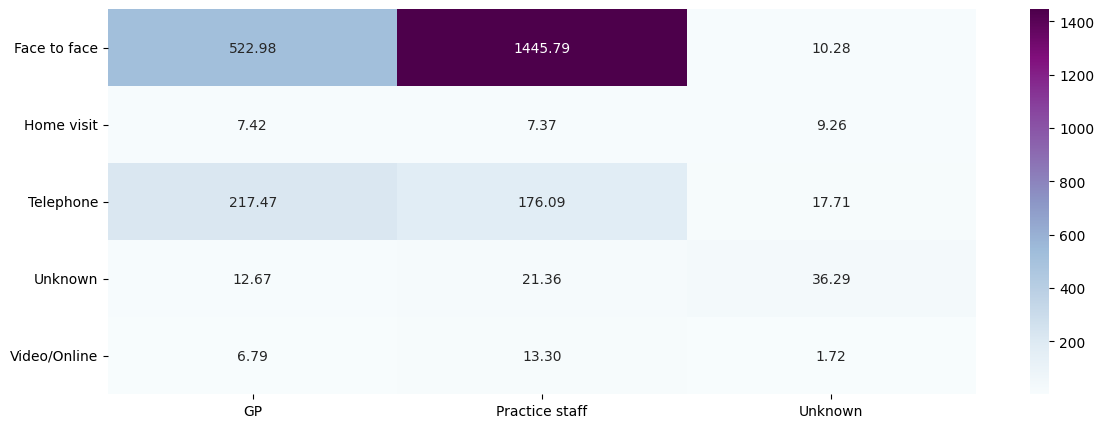

In [18]:
plt.subplots(figsize=(14,5))
sns.heatmap(national_average_dna_hcp_appt_type, annot=True, fmt='.2f', cmap='BuPu')

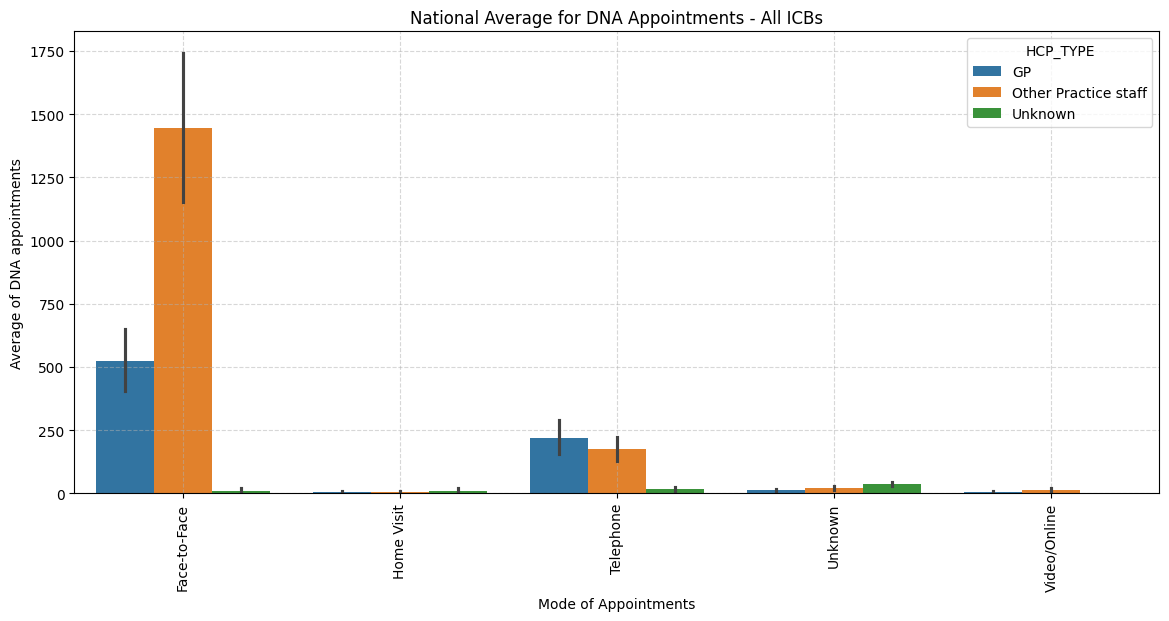

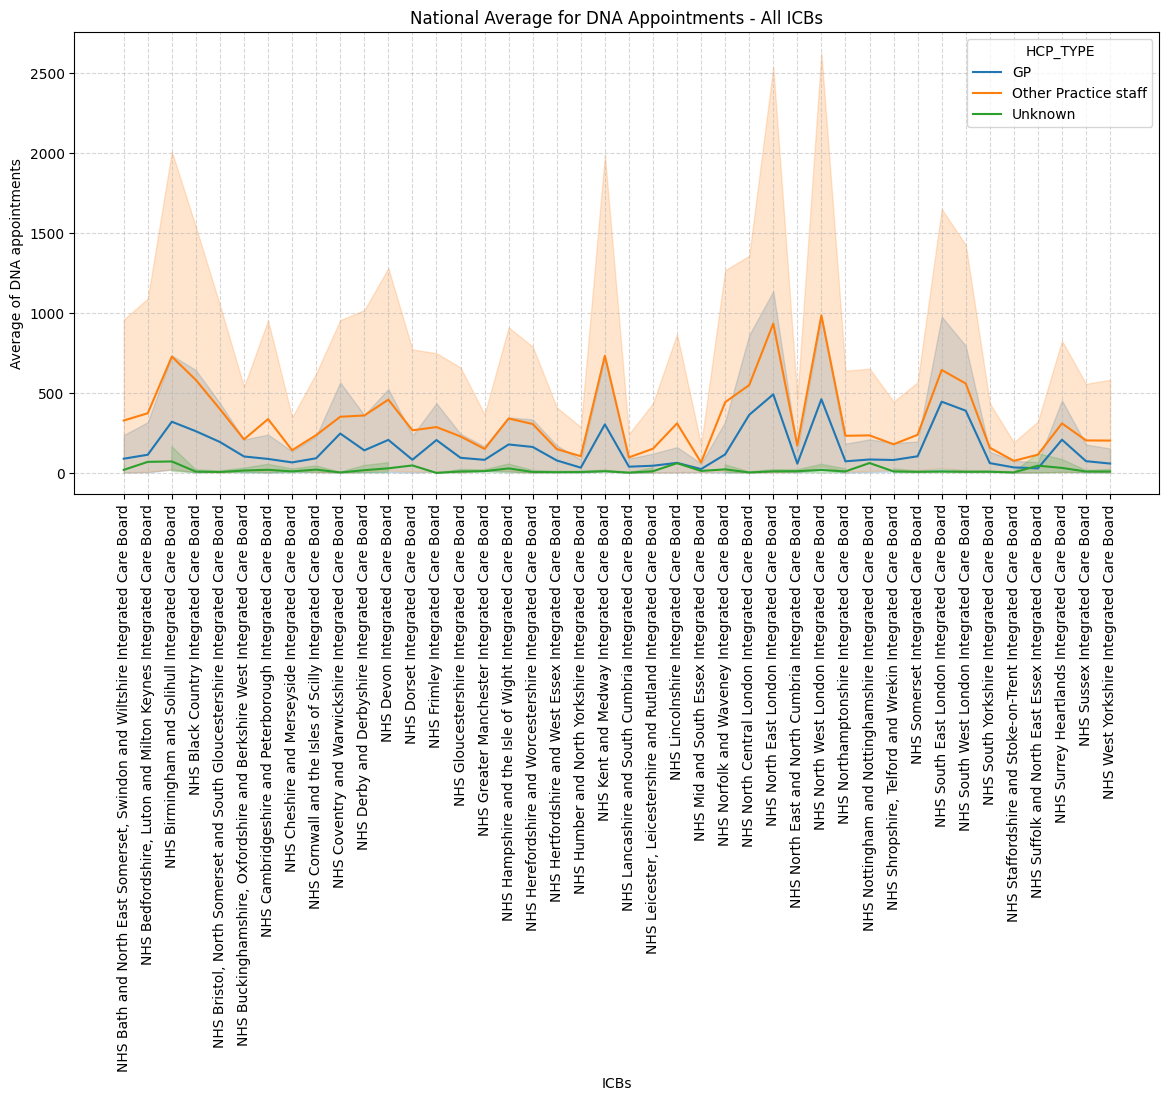

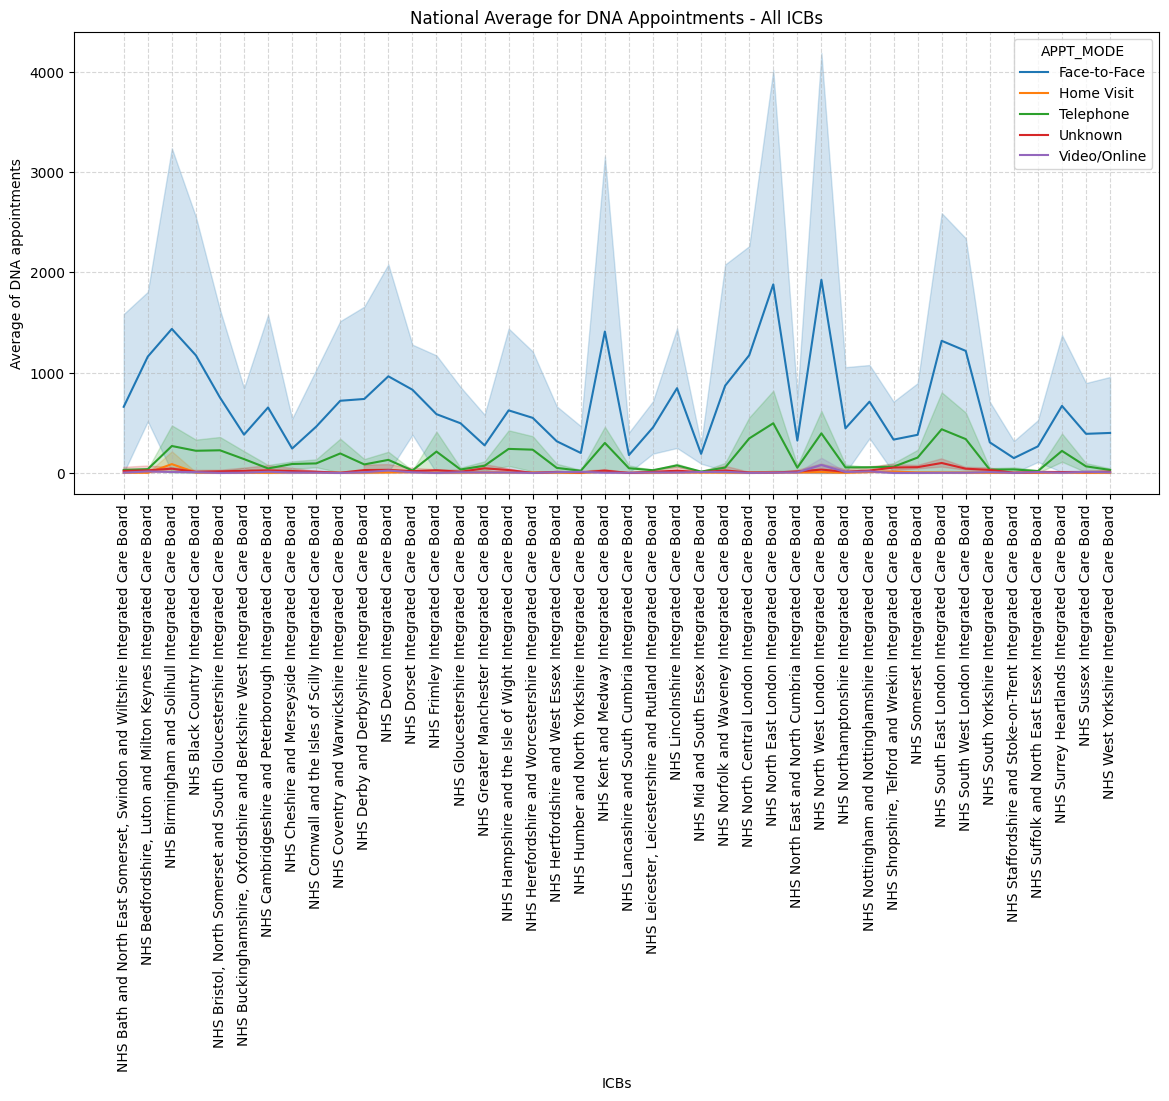

In [19]:
# Plotting the DNA appointments barplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.barplot(x='APPT_MODE', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('Mode of Appointments')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

# Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='HCP_TYPE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

# Plotting the DNA appointments lineplot
plt.subplots(figsize=(14,6))
plt.xticks(rotation=90)
sns.lineplot(x='ICB_NAME', y='COUNT_OF_APPOINTMENTS',  data=dna_hcptype_apptmode, hue='APPT_MODE')
plt.xlabel('ICBs')
plt.ylabel('Average of DNA appointments')
plt.title('National Average for DNA Appointments - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

## **Analysis using proportion(%) of appointments**

### **Pre-Processing**

In [20]:
appt_proportion_df = combined_df_copy.loc[:,['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE','APPT_STATUS','COUNT_OF_APPOINTMENTS','FY_YEAR']].pivot_table(index=['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE','FY_YEAR'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = appt_proportion_df.sum(axis=1)
appt_proportion_df = appt_proportion_df.div(sum_row, axis=0)*100
appt_proportion_df = appt_proportion_df.reset_index()
appt_proportion_df.columns = ['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE','FY_YEAR','Attended','DNA','Unknown']
appt_proportion_df

,SUB_ICB_LOCATION_NAME,HCP_TYPE,APPT_MODE,FY_YEAR,Attended,DNA,Unknown
0,NHS Bath and North East Somerset Swindon and W...,GP,Face-to-Face,FY2021,95.485783,2.096193,2.418024
1,NHS Bath and North East Somerset Swindon and W...,GP,Face-to-Face,FY2022,95.485204,2.369269,2.145526
2,NHS Bath and North East Somerset Swindon and W...,GP,Face-to-Face,FY2023,93.195754,2.505296,4.298949
3,NHS Bath and North East Somerset Swindon and W...,GP,Home Visit,FY2021,94.723969,2.480783,2.795248
4,NHS Bath and North East Somerset Swindon and W...,GP,Home Visit,FY2022,96.491228,1.682778,1.825994
...,...,...,...,...,...,...,...
3968,NHS West Yorkshire ICB - X2C4Y,Unknown,Face-to-Face,FY2021,99.456522,NaN,0.543478
3969,NHS West Yorkshire ICB - X2C4Y,Unknown,Face-to-Face,FY2022,NaN,NaN,100.000000
3970,NHS West Yorkshire ICB - X2C4Y,Unknown,Unknown,FY2021,89.345778,2.918405,7.735817
3971,NHS West Yorkshire ICB - X2C4Y,Unknown,Unknown,FY2022,88.608142,3.069003,8.322854


### **Attended Appointments** 

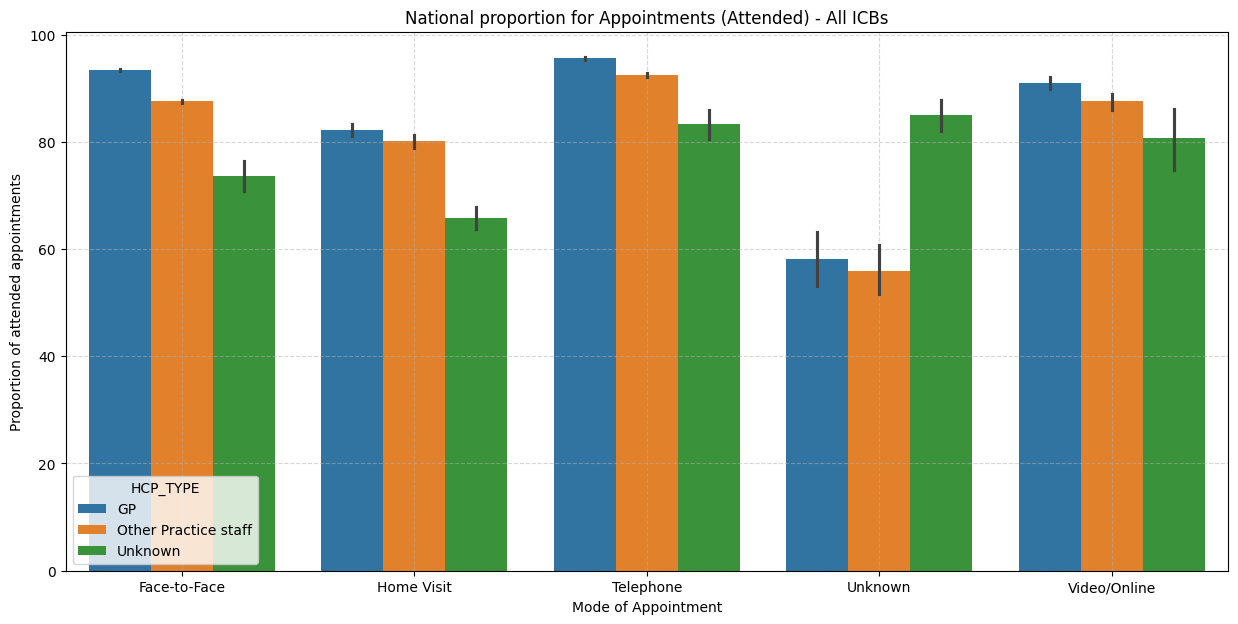

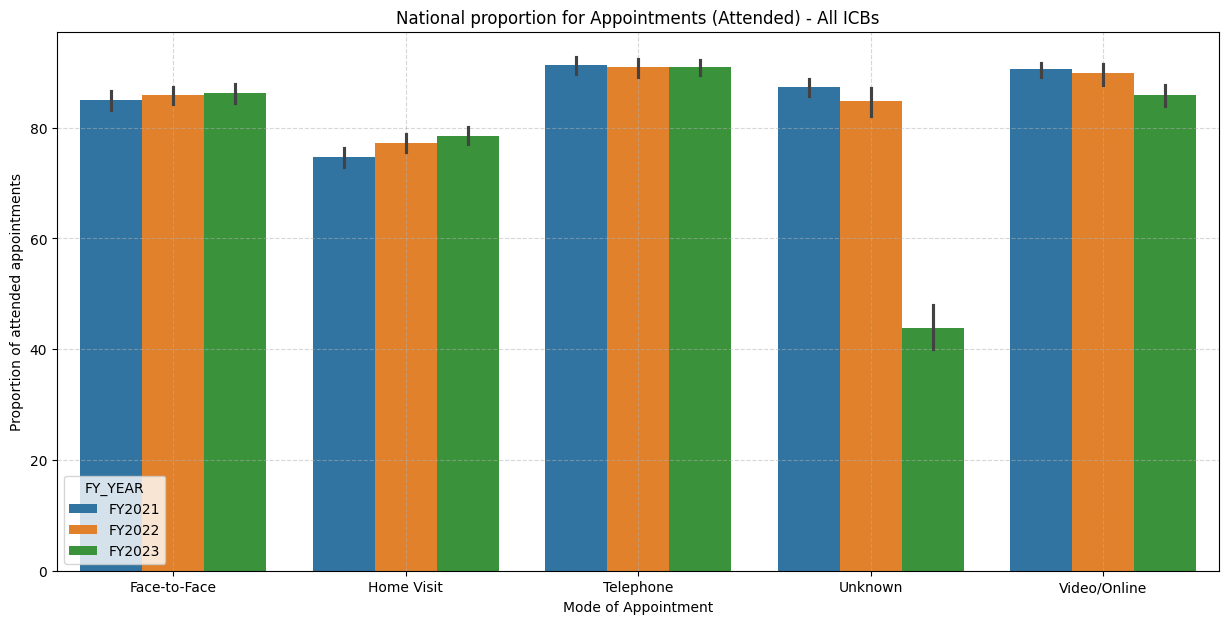

In [21]:
# Plotting the Attended appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='Attended', hue='HCP_TYPE',  data=appt_proportion_df)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'outputs/plots/{plot_counter.plot_name}.png', dpi=300)


# Plotting the Attended appointments by FY Years
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='Attended', hue='FY_YEAR',  data=appt_proportion_df)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of attended appointments')
plt.title('National proportion for Appointments (Attended) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'outputs/plots/{plot_counter.plot_name}.png', dpi=300)

### **DNA Appointments** 

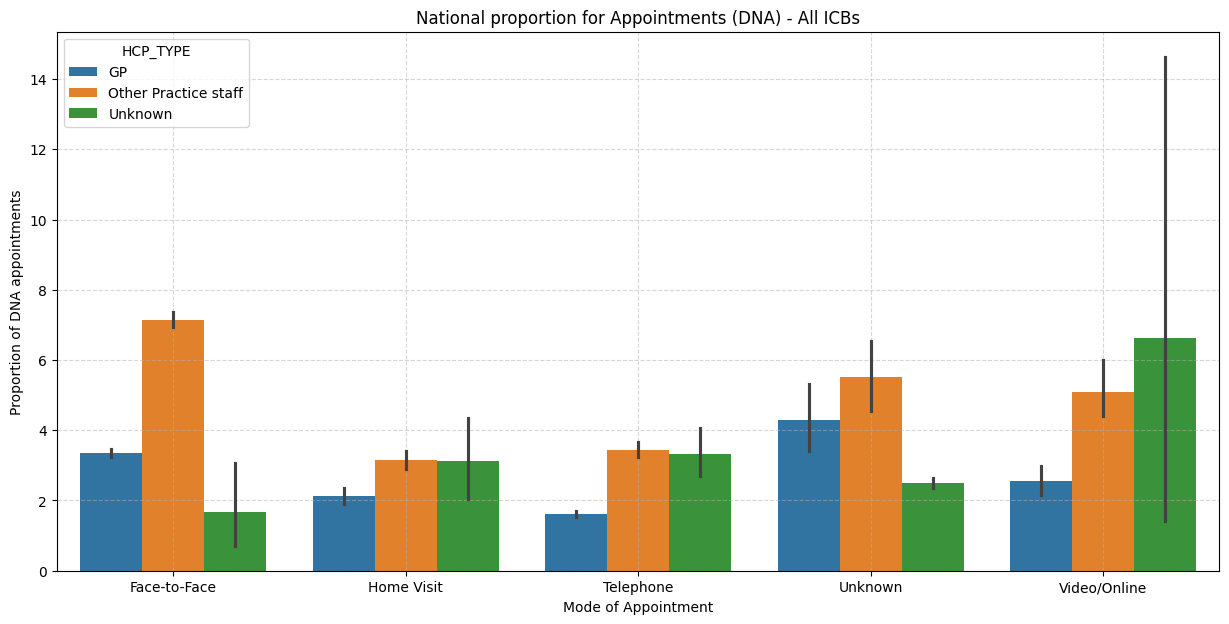

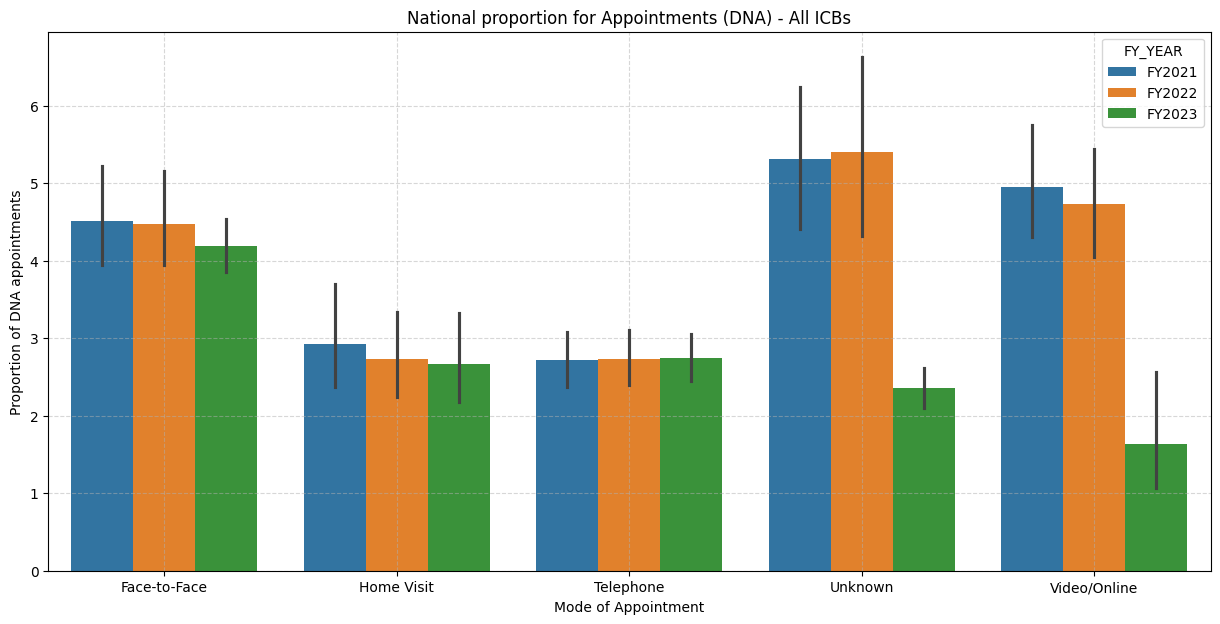

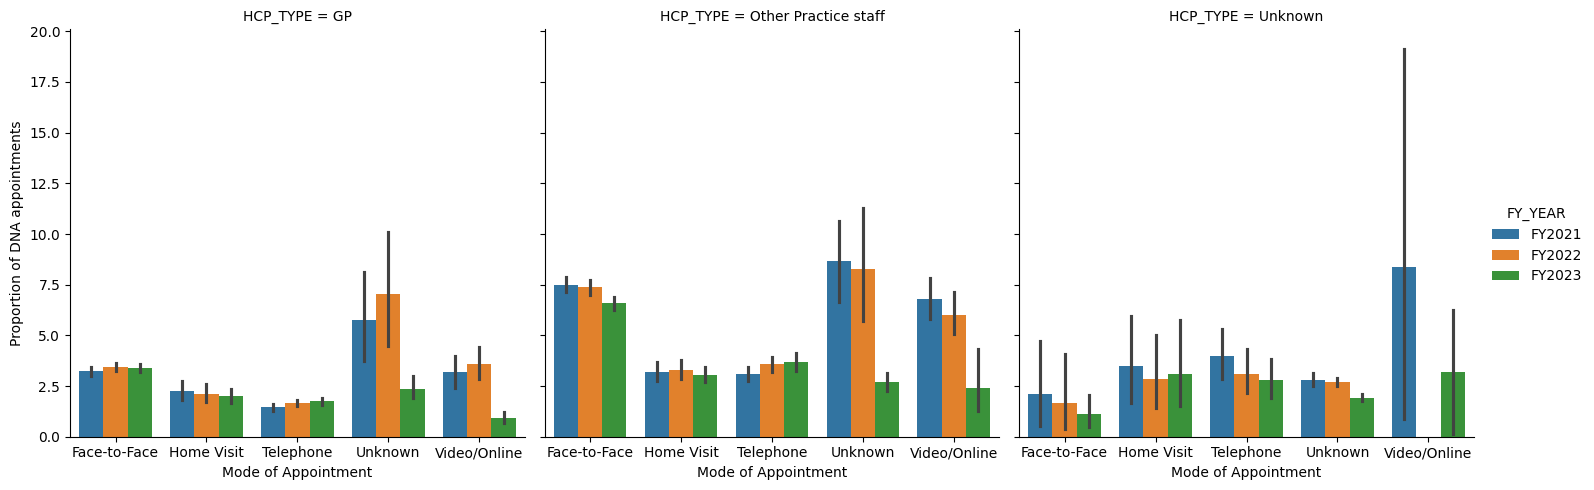

In [22]:
# Plotting the DNA appointments by HCP type
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'outputs/plots/{plot_counter.plot_name}.png', dpi=300)


# Plotting the DNA appointments by FY Year
plt.subplots(figsize=(15,7))
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df)
plt.xlabel('Mode of Appointment')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'outputs/plots/{plot_counter.plot_name}.png', dpi=300)

# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='HCP_TYPE' , kind='bar', data=appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'outputs/plots/{plot_counter.plot_name}.png', dpi=300)
plt.show()

### **Correlation matrix all sub-icb's**

In [ ]:
# Converting categorical columns to numerical
ce_OHE_all = category_encoders.OneHotEncoder(cols=['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE'])
data_all_sub_icbs = ce_OHE_all.fit_transform(appt_proportion_df).drop(columns=['FY_YEAR'])
data_all_sub_icbs.head()

,SUB_ICB_LOCATION_NAME_1,SUB_ICB_LOCATION_NAME_2,SUB_ICB_LOCATION_NAME_3,SUB_ICB_LOCATION_NAME_4,SUB_ICB_LOCATION_NAME_5,SUB_ICB_LOCATION_NAME_6,SUB_ICB_LOCATION_NAME_7,SUB_ICB_LOCATION_NAME_8,SUB_ICB_LOCATION_NAME_9,SUB_ICB_LOCATION_NAME_10,...,HCP_TYPE_2,HCP_TYPE_3,APPT_MODE_1,APPT_MODE_2,APPT_MODE_3,APPT_MODE_4,APPT_MODE_5,Attended,DNA,Unknown
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,95.485783,2.096193,2.418024
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,95.485204,2.369269,2.145526
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,93.195754,2.505296,4.298949
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,94.723969,2.480783,2.795248
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,96.491228,1.682778,1.825994


In [ ]:
dna_correlations_all_sub_icbs = data_all_sub_icbs.corr()['DNA'].sort_values(ascending=False)
with pd.option_context('display.max_rows', None):
    print(dna_correlations_all_sub_icbs)

DNA                          1.000000
HCP_TYPE_2                   0.218350
SUB_ICB_LOCATION_NAME_3      0.156437
APPT_MODE_1                  0.107360
SUB_ICB_LOCATION_NAME_96     0.085231
SUB_ICB_LOCATION_NAME_4      0.059735
SUB_ICB_LOCATION_NAME_92     0.059042
SUB_ICB_LOCATION_NAME_41     0.052528
APPT_MODE_4                  0.047271
SUB_ICB_LOCATION_NAME_71     0.039740
SUB_ICB_LOCATION_NAME_17     0.037359
SUB_ICB_LOCATION_NAME_43     0.034236
SUB_ICB_LOCATION_NAME_26     0.030586
SUB_ICB_LOCATION_NAME_76     0.029633
SUB_ICB_LOCATION_NAME_73     0.028562
APPT_MODE_5                  0.027925
SUB_ICB_LOCATION_NAME_85     0.025873
SUB_ICB_LOCATION_NAME_77     0.022731
SUB_ICB_LOCATION_NAME_80     0.021860
SUB_ICB_LOCATION_NAME_83     0.021764
SUB_ICB_LOCATION_NAME_74     0.018921
SUB_ICB_LOCATION_NAME_31     0.015942
SUB_ICB_LOCATION_NAME_2      0.015893
SUB_ICB_LOCATION_NAME_35     0.015371
SUB_ICB_LOCATION_NAME_34     0.014960
SUB_ICB_LOCATION_NAME_50     0.014067
SUB_ICB_LOCA

### **SNEE sub-icb Analysis**

In [ ]:
snee_sub_icb = ['NHS Suffolk and North East Essex ICB - 06L','NHS Suffolk and North East Essex ICB - 06T','NHS Suffolk and North East Essex ICB - 07K']
snee_appt_proportion_df = appt_proportion_df.loc[appt_proportion_df['SUB_ICB_LOCATION_NAME'].isin(snee_sub_icb)]
snee_appt_proportion_df['SUB_ICB_LOCATION_NAME'] = snee_appt_proportion_df['SUB_ICB_LOCATION_NAME'].replace({'NHS Suffolk and North East Essex ICB - 06L':'Ipswich & East Suffolk',
                                                                                                             'NHS Suffolk and North East Essex ICB - 06T':'North East Essex',
                                                                                                             'NHS Suffolk and North East Essex ICB - 07K':'West Suffolk'})
snee_appt_proportion_df = snee_appt_proportion_df.groupby(['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE','FY_YEAR']).mean()

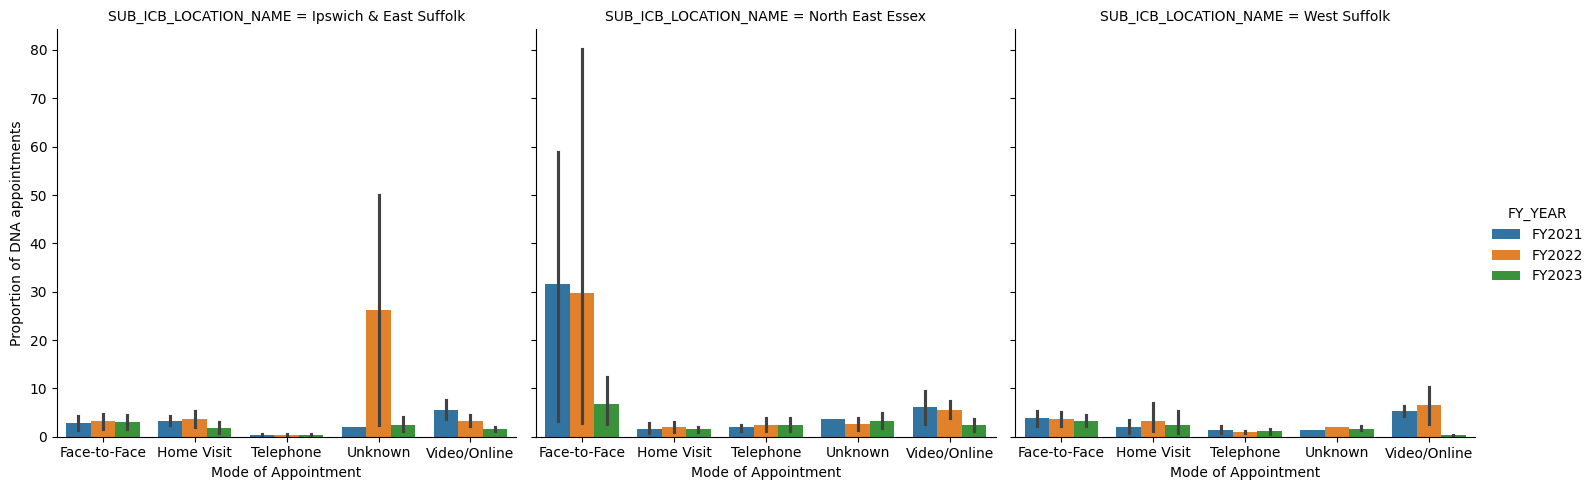

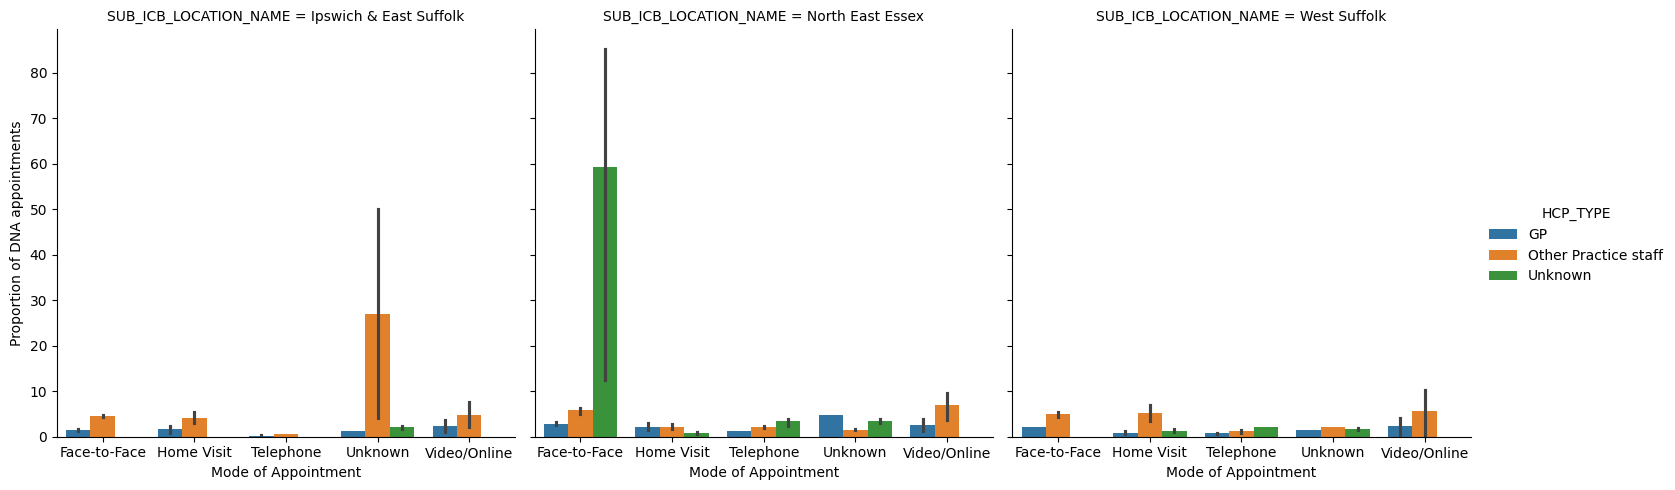

In [27]:
# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='FY_YEAR', col='SUB_ICB_LOCATION_NAME' , kind='bar', data=snee_appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'outputs/plots/{plot_counter.plot_name}.png', dpi=300)
plt.show()

# Plotting the DNA appointments by FY Year
fig = sns.catplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE', col='SUB_ICB_LOCATION_NAME' , kind='bar', data=snee_appt_proportion_df)
fig.set_xlabels('Mode of Appointment')
fig.set_ylabels('Proportion of DNA appointments')
plt.savefig(f'outputs/plots/{plot_counter.plot_name}.png', dpi=300)
plt.show()

In [ ]:
snee_appt_proportion_df = snee_appt_proportion_df.reset_index()

### **Correlation matrix SNEE sub-icb's**

In [ ]:
ce_OHE = category_encoders.OneHotEncoder(cols=['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE'])
data_snee = ce_OHE.fit_transform(snee_appt_proportion_df).drop(columns=['FY_YEAR'])
data_snee.tail()

,SUB_ICB_LOCATION_NAME_1,SUB_ICB_LOCATION_NAME_2,SUB_ICB_LOCATION_NAME_3,HCP_TYPE_1,HCP_TYPE_2,HCP_TYPE_3,APPT_MODE_1,APPT_MODE_2,APPT_MODE_3,APPT_MODE_4,APPT_MODE_5,Attended,DNA,Unknown
106,0,0,1,0,0,1,0,0,1,0,0,100.000000,NaN,NaN
107,0,0,1,0,0,1,0,0,1,0,0,NaN,NaN,100.000000
108,0,0,1,0,0,1,0,0,0,1,0,96.118702,1.430525,2.450773
109,0,0,1,0,0,1,0,0,0,1,0,94.421558,1.966858,3.611584
110,0,0,1,0,0,1,0,0,0,1,0,93.489261,1.481826,5.028914


In [ ]:
dna_correlations_snee_sub_icbs = data_snee.corr()['DNA'].sort_values(ascending=False)
dna_correlations_snee_sub_icbs

DNA                        1.000000
APPT_MODE_1                0.283448
HCP_TYPE_3                 0.220149
SUB_ICB_LOCATION_NAME_2    0.162989
APPT_MODE_4                0.014059
HCP_TYPE_2                 0.009638
Unknown                   -0.019996
APPT_MODE_5               -0.028370
SUB_ICB_LOCATION_NAME_1   -0.041996
APPT_MODE_2               -0.113701
SUB_ICB_LOCATION_NAME_3   -0.128406
APPT_MODE_3               -0.147838
HCP_TYPE_1                -0.196048
Attended                  -0.577497
Name: DNA, dtype: float64

## **Inferences and Results**

### 1. Are SNEE sub-ICB missed appointments greater than the national average (in FY 2022)?

In [ ]:
print(f'{National_average_DNA.item()} is the National average for DNA appointments (FY-2021-22-23)')
print(f'{SNEE_average_DNA.mean().item()} is the SNEE average for DNA appointments(FY-2021-22-23)')
print(f'{National_average_DNA_2022.item()} is the National average DNA attend appointments(FY-2022)')

SNEE_average_DNA

304.1467 is the National average for DNA appointments (FY-2021-22-23)
101.2273 is the SNEE average for DNA appointments(FY-2021-22-23)
334.4385 is the National average DNA attend appointments(FY-2022)


,COUNT_OF_APPOINTMENTS
FY_YEAR,
FY2021,106.1100
FY2022,106.1922
FY2023,91.3797


- We can see that the overall average for non-attended appointments for SNEE-ICB is 101, which is much lesser than National Average of 304
  
- For year 2022, this difference increases as the National average increases from 304 to 334, whereas for SNEE-ICB the change is from 101 to 106

### 2. Are the missed appointments proportion (%) consistent over time using multiple years?

- The missed appointments are consistent over years when appointment mode is Face to Face, home visit or telephonic
- The missed appointments are not consistent over years when appointment mode is UNknown or Video/ONline

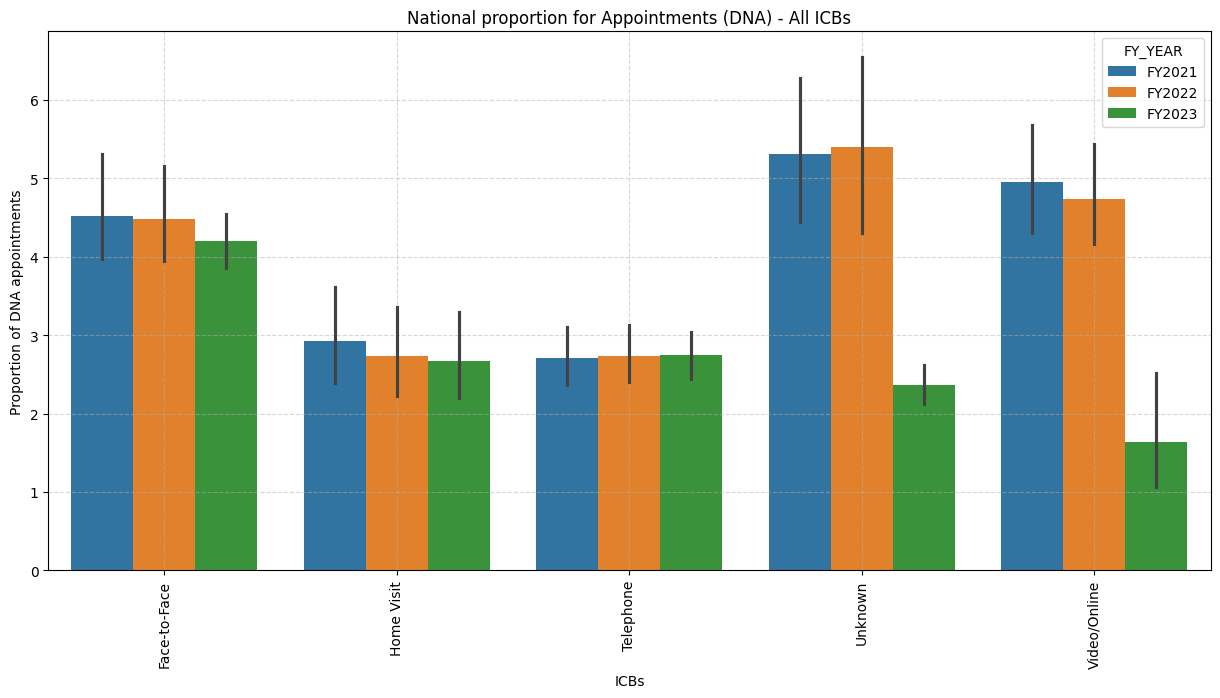

In [ ]:
# Plotting the DNA appointments by FY Year
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.barplot(x='APPT_MODE', y='DNA', hue='FY_YEAR',  data=appt_proportion_df)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

### 3. Across staff groups & Sub-ICB, are some appointments more likely to be missed?


- Appointments that are with 'other practice staff' are most likely to be missed specially when mode of appointments is Face to Face, followed by UNknown

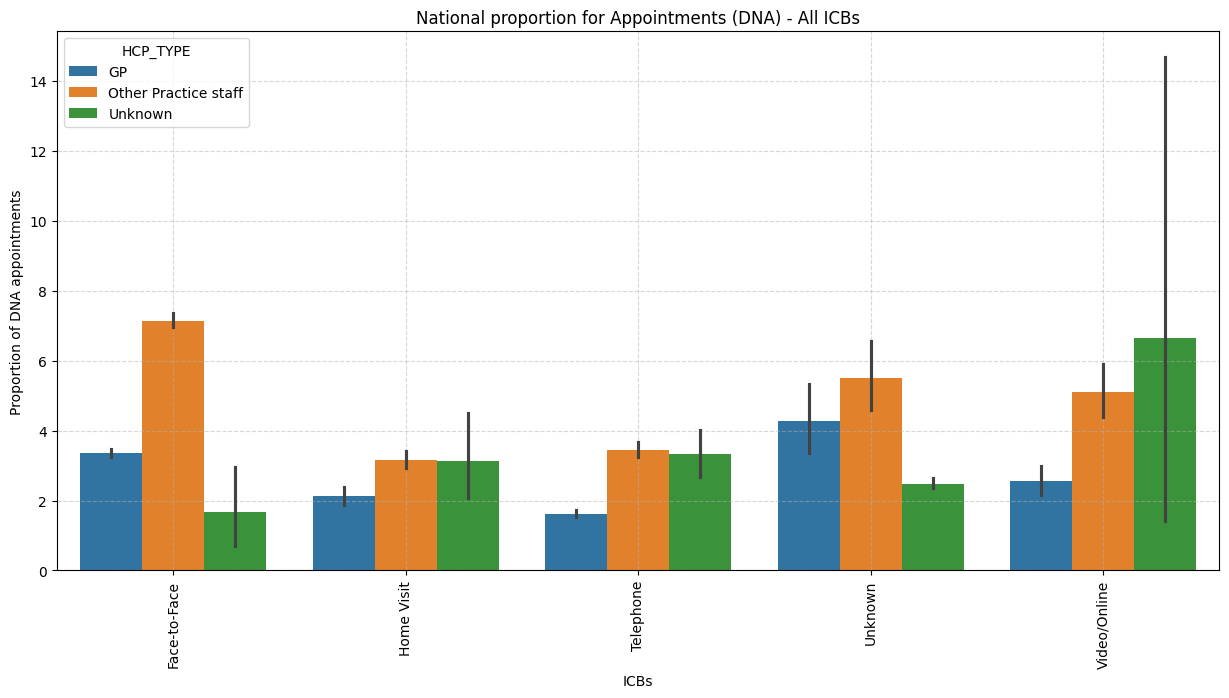

In [ ]:
# Plotting the DNA appointments by HCP type
plt.subplots(figsize=(15,7))
plt.xticks(rotation=90)
sns.barplot(x='APPT_MODE', y='DNA', hue='HCP_TYPE',  data=appt_proportion_df)
plt.xlabel('ICBs')
plt.ylabel('Proportion of DNA appointments')
plt.title('National proportion for Appointments (DNA) - All ICBs')
plt.grid(True, linestyle='--', alpha=0.5)

### 4. What is the mean likelihood that someone  Will not attend? from a combination of Sub-ICB, Staff type, Appointment type. 
5. to determine if a patient with the above appointment will attend.

#### 1. **For Snee ICB'S**

In [ ]:
print(dna_correlations_snee_sub_icbs)

DNA                        1.000000
APPT_MODE_1                0.283448
HCP_TYPE_3                 0.220149
SUB_ICB_LOCATION_NAME_2    0.162989
APPT_MODE_4                0.014059
HCP_TYPE_2                 0.009638
Unknown                   -0.019996
APPT_MODE_5               -0.028370
SUB_ICB_LOCATION_NAME_1   -0.041996
APPT_MODE_2               -0.113701
SUB_ICB_LOCATION_NAME_3   -0.128406
APPT_MODE_3               -0.147838
HCP_TYPE_1                -0.196048
Attended                  -0.577497
Name: DNA, dtype: float64


- From the above Correlation matrix, we can infer the likelihood that a person in SNEE area will not attend (dna) appointment.
- Positive Correlation - if Appointment mode= (1 or Face-to-face) and HCP-TYPE= (3 or Unknown), then the person is most likely to **NOT ATTEND**
- Negative correlation - if HCP-TYPE = (1 or GP), then the person is most likely to **Attend**
- Interesting to note that if a person belongs to sub-icb North East Essex then its likely to not attend but the correlation is not very strong, so we cannot be very sure. Same goes for west suffolk but in a negative way (person is likely to attend) but again the correlation is not very strong

#### 2. **For all sub-icbs(102)**

In [ ]:
with pd.option_context('display.max_rows', None):
    print(dna_correlations_all_sub_icbs)

DNA                          1.000000
HCP_TYPE_2                   0.218350
SUB_ICB_LOCATION_NAME_3      0.156437
APPT_MODE_1                  0.107360
SUB_ICB_LOCATION_NAME_96     0.085231
SUB_ICB_LOCATION_NAME_4      0.059735
SUB_ICB_LOCATION_NAME_92     0.059042
SUB_ICB_LOCATION_NAME_41     0.052528
APPT_MODE_4                  0.047271
SUB_ICB_LOCATION_NAME_71     0.039740
SUB_ICB_LOCATION_NAME_17     0.037359
SUB_ICB_LOCATION_NAME_43     0.034236
SUB_ICB_LOCATION_NAME_26     0.030586
SUB_ICB_LOCATION_NAME_76     0.029633
SUB_ICB_LOCATION_NAME_73     0.028562
APPT_MODE_5                  0.027925
SUB_ICB_LOCATION_NAME_85     0.025873
SUB_ICB_LOCATION_NAME_77     0.022731
SUB_ICB_LOCATION_NAME_80     0.021860
SUB_ICB_LOCATION_NAME_83     0.021764
SUB_ICB_LOCATION_NAME_74     0.018921
SUB_ICB_LOCATION_NAME_31     0.015942
SUB_ICB_LOCATION_NAME_2      0.015893
SUB_ICB_LOCATION_NAME_35     0.015371
SUB_ICB_LOCATION_NAME_34     0.014960
SUB_ICB_LOCATION_NAME_50     0.014067
SUB_ICB_LOCA

- In all the sub-icb's we can infer from above correlations that if HCP-TYPE = (2 OR Other Practice staff), Then its most likely by someone to not attend the appointment

### 6. Persist the distribution information from 5. to a yaml file.

In [28]:
combined_df['APPOINTMENT_MONTH'].unique()

array(['MAR2021', 'APR2021', 'MAY2021', 'JUN2021', 'JUL2021', 'AUG2021',
       'SEP2021', 'OCT2021', 'NOV2021', 'DEC2021', 'JAN2022', 'FEB2022',
       'MAR2022', 'APR2022', 'MAY2022', 'JUN2022', 'JUL2022', 'AUG2022',
       'SEP2022', 'OCT2022', 'NOV2022', 'DEC2022', 'JAN2023', 'FEB2023',
       'MAR2023', 'APR2023', 'MAY2023', 'JUN2023', 'JUL2023', 'AUG2023'],
      dtype=object)

In [29]:
months_to_keep = ['SEP2022', 'OCT2022', 'NOV2022', 'DEC2022', 'JAN2023', 'FEB2023', 'MAR2023', 'APR2023', 'MAY2023', 'JUN2023', 'JUL2023', 'AUG2023']

filtered_df = combined_df[combined_df['APPOINTMENT_MONTH'].isin(months_to_keep)]

filtered_df = filtered_df.loc[:,['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE','APPT_STATUS','COUNT_OF_APPOINTMENTS','APPOINTMENT_MONTH']].pivot_table(index=['SUB_ICB_LOCATION_NAME','HCP_TYPE','APPT_MODE'], columns=['APPT_STATUS'], values=['COUNT_OF_APPOINTMENTS'], aggfunc='sum')

# Converting number of attended/dna/unknown to proportions
sum_row = filtered_df.sum(axis=1)
filtered_df = filtered_df.div(sum_row, axis=0).round(4)

filtered_df = filtered_df.drop(columns=[('COUNT_OF_APPOINTMENTS', 'Attended'),('COUNT_OF_APPOINTMENTS',  'Unknown')])
filtered_df.columns = filtered_df.columns.to_flat_index()
filtered_df.rename(columns={('COUNT_OF_APPOINTMENTS', 'DNA'): 'DNA'}, inplace=True)
filtered_df

DNA
SUB_ICB_LOCATION_NAME                              HCP_TYPE             APPT_MODE           
NHS Bath and North East Somerset Swindon and Wi... GP                   Face-to-Face  0.0245
                                                                        Home Visit    0.0096
                                                                        Telephone     0.0033
                                                                        Unknown       0.0219
                                                                        Video/Online  0.0129
...                                                                                      ...
NHS West Yorkshire ICB - X2C4Y                     Other Practice staff Telephone     0.0097
                                                                        Unknown       0.0428
                                                                        Video/Online  0.0423
                                                   Unknown              Face-to-Face     NaN
                                                                        Unknown       0.0306

[1449 rows x 1 columns]

In [30]:
# Converting to Dictionary
dna_proportion_dict = filtered_df.squeeze().to_dict()

In [31]:
# To get the desired format in dictionary - {"ICB_code":  {"GP" {"In person" : 0.04 , "Online": 0.02, "Telephone", . . .}, . . .}, . . .}
nested_dna_proportion_dict = {}

for key, value in dna_proportion_dict.items():
    icb_name, hcp_type, appt_mode = key
    icb_name, icb_code = icb_name.split(' - ')
    if icb_code not in nested_dna_proportion_dict:
        nested_dna_proportion_dict[icb_code] = {}
    if hcp_type not in nested_dna_proportion_dict[icb_code]:
        nested_dna_proportion_dict[icb_code][hcp_type] = {}
    nested_dna_proportion_dict[icb_code][hcp_type][appt_mode] = value

In [32]:
OUTPUT_YAML_FILE = "outputs/assumptions/dna_appointments.yaml"

# Output to yaml
with open(OUTPUT_YAML_FILE, 'w') as yaml_file:
    yaml.dump(nested_dna_proportion_dict, yaml_file)